In [58]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from load_data import *
from Utility import plot_psd

np.set_printoptions(precision=3)

# Loading preprocessed data (that is already filtered with linear fir)

<IPython.core.display.Javascript object>


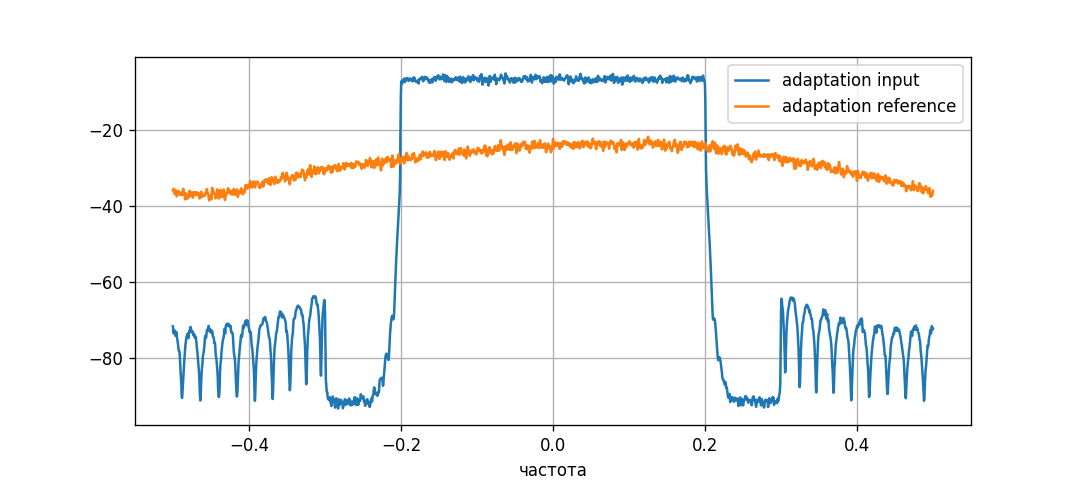

In [2]:
%matplotlib notebook

# adaptation input and reference
a_in, a_ref = load_for_non_linear_adaptation("data/test1_25p0.mat")

# normalization of input and reference dynamic range to [-1, 1]
# it helps with numerical acuuracy, especially when we are wroking with raw polynomials
# it is also necessary if we are going to use chebyshev or other polynomials 
a_max = np.max(np.hstack([np.abs(a_in.real), np.abs(a_in.imag), np.abs(a_ref.real), np.abs(a_ref.imag)]))
a_in/=a_max
a_ref/=a_max

# plot input data
fig, ax = plt.subplots(1, 1, figsize=(9, 4))
plot_psd([a_in, a_ref], ax=ax)

plt.legend(['adaptation input', 'adaptation reference'])

# Simple model without memory (here and everywhere using LS)
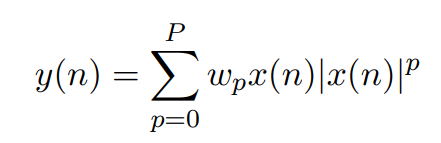

In [23]:
# polynomial generation functions

def gen_poly_default(u, poly_ord):
    """
    :brief: generates default polynomial of powers of u
    :param u: argument (attention!! if you want poly from abs you should pass abs(u))
    :param poly_ord: order of polynomial
    """
    res = np.zeros((poly_ord+1, u.shape[0]), dtype=u.dtype)
    for p in range(0, poly_ord+1):
        res[p] = u**p
    
    return res


def gen_poly_default_even(u, poly_ord):
    """
    :brief: generates default polynomial of even powers of u
    :param u: argument (attention!! if you want poly from abs you should pass abs(u))
    :param poly_ord: order of polynomial
    """
    return gen_poly_default(u, poly_ord)[::2]


def gen_cheby1_poly(u, poly_ord):
    """
    :brief: generates chebyshev polynomial of 1 kind
    :param u: argument (attention!! if you want poly from abs you should pass abs(u))
    :param poly_ord: order of polynomial
    """
    res = np.zeros((poly_ord+1, u.shape[0]), dtype=u.dtype)
    res[0] = 1
    if poly_ord > 0:
        res[1] = u
    
    for p in range(2, poly_ord+1):
        res[p] = 2*u*res[p-1] - res[p-2]
    
    return res


def gen_cheby2_poly(u, poly_ord):
    """
    :brief: generates chebyshev polynomial of 2 kind
    :param u: argument (attention!! if you want poly from abs you should pass abs(u))
    :param poly_ord: order of polynomial
    """
    res = np.zeros((poly_ord+1, u.shape[0]), dtype=u.dtype)
    res[0] = 1
    if poly_ord > 0:
        res[1] = 2*u
    
    for p in range(2, poly_ord+1):
        res[p] = 2*u*res[p-1] - res[p-2]
    
    return res


def gen_hermit_poly(u, poly_ord):
    """
    :brief: generates hermite polinomial
    :param u: argument (attention!! if you want poly from abs you should pass abs(u))
    :param poly_ord: order of polynomial
    """
    res = np.zeros((poly_ord+1, u.shape[0]), dtype=u.dtype)
    res[0] = 1
    if poly_ord > 0:
        res[1] = 2*u
    
    for p in range(2, poly_ord+1):
        res[p] = 2*u*res[p-1] - 2*(p-1)*res[p-2]
    
    return res


In [10]:
def polynomial_no_mem(u, d, poly_ord, poly_generator=gen_poly_default, sigma=0., rcond=0.):
    """
    :param u: system input
    :param d: reference signal
    :param poly_ord: order of polynomial to use
    :return: w - resulting filter coefficients, y - filter output
    """
    
    # extend signal with orders of u
    poly = poly_generator(np.abs(u), poly_ord)
    
    u_ext = u * poly
    
    u_ext = u_ext.T
    u_ext_H = u_ext.T.conj()
        
    w = np.linalg.pinv((u_ext_H @ u_ext) + (sigma**2) * np.eye(poly.shape[0]), rcond=rcond) @ u_ext_H @ d
    
    y = u_ext @ w
    
    return w, y
    

<IPython.core.display.Javascript object>


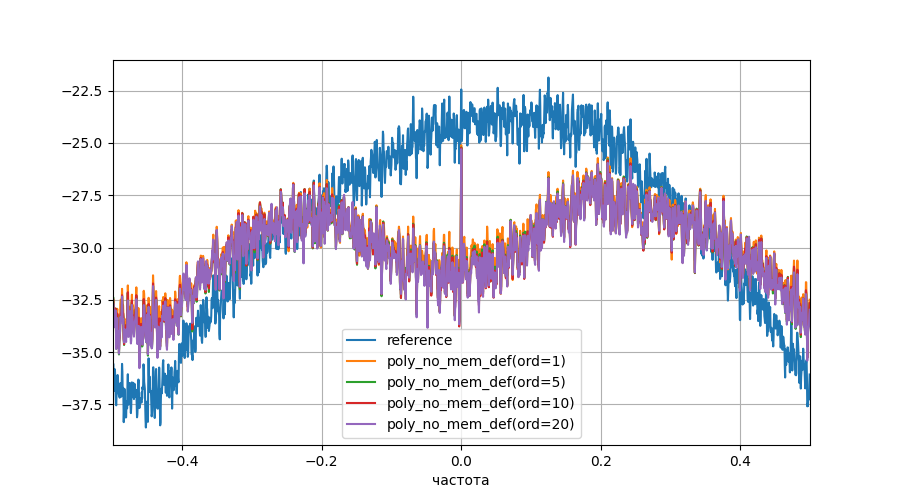

<IPython.core.display.Javascript object>


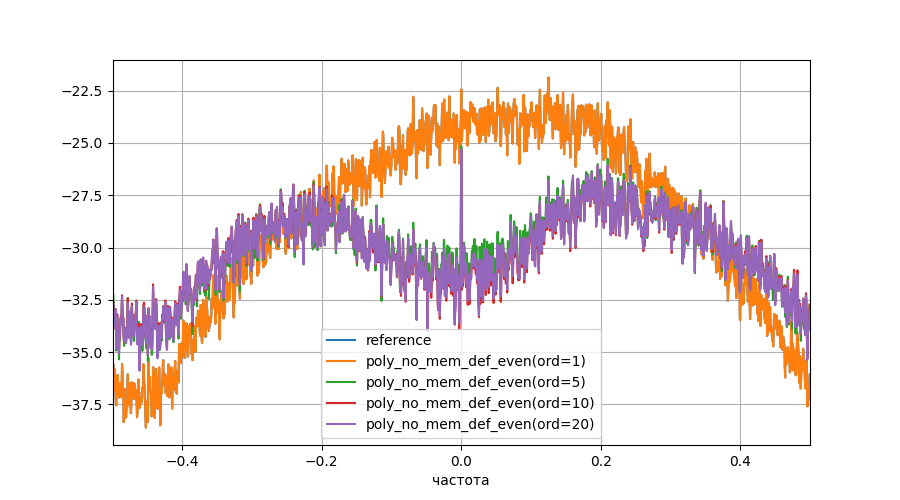

<IPython.core.display.Javascript object>


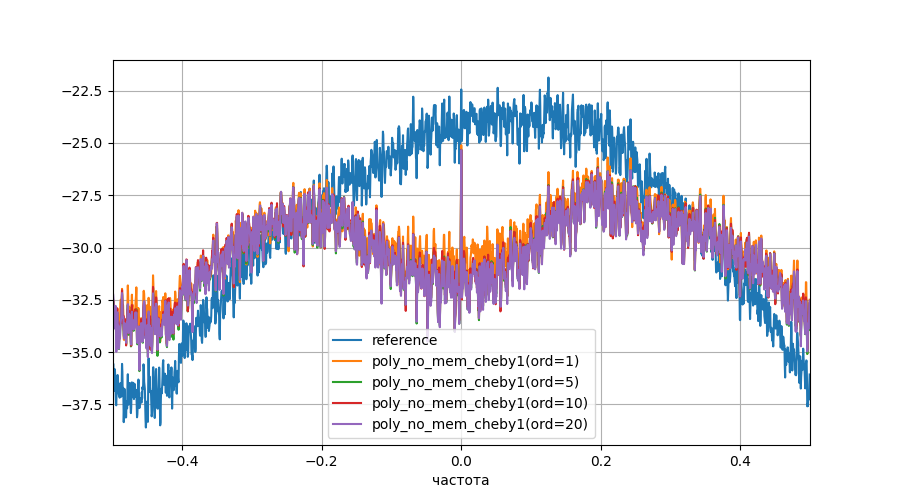

<IPython.core.display.Javascript object>


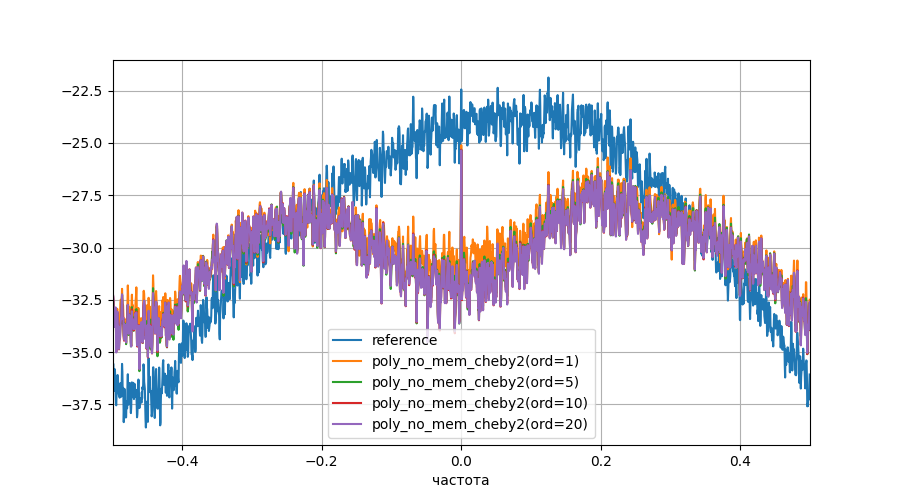

<IPython.core.display.Javascript object>


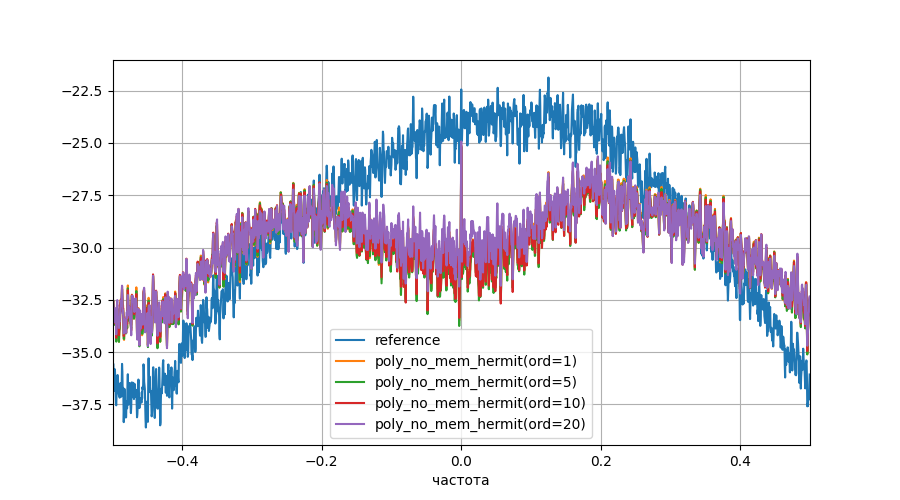

<IPython.core.display.Javascript object>


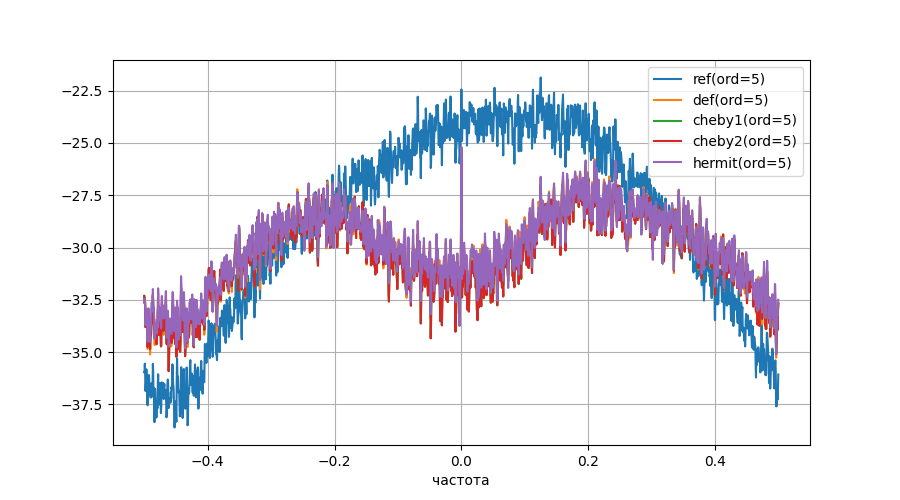

In [26]:
%matplotlib notebook
# try polynomial of different orders
poly_no_mem_orders = [1, 5, 10, 20]
poly_generators = [('def',gen_poly_default) , 
                   ('def_even', gen_poly_default_even), 
                   ('cheby1', gen_cheby1_poly), 
                   ('cheby2', gen_cheby2_poly),
                   ('hermit', gen_hermit_poly)
                  ]

poly_no_mem_ws = dict()
poly_no_mem_errs = dict()

for poly_name, poly_gen in poly_generators:
    poly_no_mem_ws[poly_name] = []
    poly_no_mem_errs[poly_name] = []
    for poly_no_mem_ord in poly_no_mem_orders:
        # default poly
        w_tmp, y_tmp = polynomial_no_mem(a_in, a_ref, poly_no_mem_ord, 
                                         poly_generator=poly_gen, rcond=1e-3)
        poly_no_mem_ws[poly_name].append(w_tmp)
        poly_no_mem_errs[poly_name].append(a_ref-y_tmp)


for poly_name, _ in poly_generators:
    # plot errors
    fig, ax = plt.subplots(1, 1, figsize=(9, 5))
    plot_psd([a_ref] + poly_no_mem_errs[poly_name], ax=ax)

    legend = ['reference'] + ['poly_no_mem_{}(ord={})'.format(poly_name, order) for order in poly_no_mem_orders]
    plt.legend(legend)
    plt.xlim(-0.5, 0.5)

# plot comparison between different polynomial
comp_ind = 1
fig, ax = plt.subplots(1, 1, figsize=(9, 5))

plot_psd([a_ref], ax=ax)
legend = ['ref(ord={})'.format(poly_no_mem_orders[comp_ind])]
for poly_name in ['def', 'cheby1', 'cheby2', 'hermit']:
    plot_psd([poly_no_mem_errs[poly_name][comp_ind]], ax=ax)
    legend += [poly_name+'(ord={})'.format(poly_no_mem_orders[comp_ind])]

plt.legend(legend)
plt.grid(True)

    

# данный метод дает довольно плохие результаты и результаты не сильно улучшаются с увеличением степени многочлена.

# ожидаемо примерно те же результаты, полиномы гарантируют только большую численную устойчивость. (и возможно некоторые небольшие преимущества при обучении т.к. признаковое пространство получается "отнормированым" в диапазон примерно [-1, 1]

# расширенная полиномиальная модель
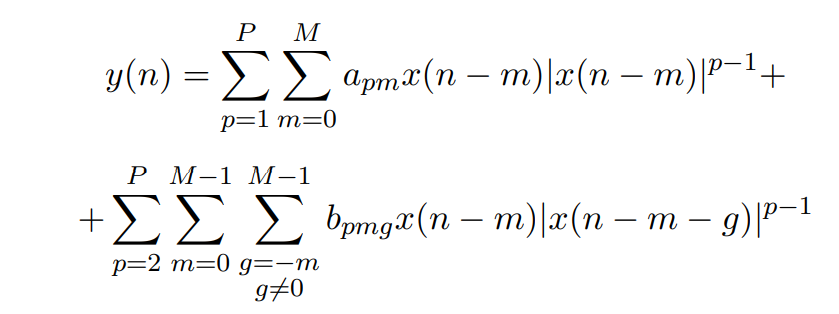

In [68]:
def learnable_all(mx_delay):
    return np.ones((ext_poly_mx_delay, ext_poly_mx_delay))


def learnable_diag(mx_delay):
    return np.eye(ext_poly_mx_delay)


def extended_polynomial(u, d, mx_delay, 
                        poly_ord, poly_generator=gen_poly_default, 
                        learnable=None, sigma=0., rcond=0.):
    """
    :param u: system input
    :param d: reference signal
    :param poly_ord: order of polynomial to use
    :param mx_delay: max delay to get on both poly and u lines
    :param learnable: map which parameters are learnable diagonal match to a and others match to b 
     (if None only diagonal are learnable)
    :return: w - resulting filter coefficients, y - filter output
    """
    u = u.copy()
    d = d.copy()
    
    if learnable is None:
        learnable = np.zeros((poly_ord + 1, mx_delay, mx_delay))
        for p in range(poly_ord+1):
            learnable[p] = np.eye(mx_delay)
    
    # if given only to dimensions, broadcast them on all the polynomial orders
    elif learnable.ndim == 2:
        learnable_tmp = learnable
        learnable = np.zeros((poly_ord + 1, mx_delay, mx_delay))
        for p in range(poly_ord+1):
            learnable[p] = learnable_tmp
    
    # extend time line
    u_ext = np.pad(u, (mx_delay - (mx_delay//2) - 1, mx_delay//2), mode='constant', constant_values=(0, 0))
    polys = poly_generator(np.abs(u_ext), poly_ord)
    
    P_shape = polys.shape[0]
    
    #generate feature matrix
    #                     a parameters               b parameters
    U_mat = np.zeros(( (mx_delay * P_shape) + (mx_delay*(mx_delay-1) * (P_shape-1)) , d.shape[0] ), dtype=np.complex128)
    
    offset = 0
    for order in range(P_shape):
        # first a
        for a_delay in range(mx_delay):
            # throw out not learnable features
            if not learnable[order][a_delay][a_delay]:
                continue
                
            U_mat[offset] = u_ext[u_ext.shape[0]-a_delay-d.shape[0]:u_ext.shape[0]-a_delay] * \
                            polys[order][u_ext.shape[0]-a_delay-d.shape[0]:u_ext.shape[0]-a_delay]
            offset += 1
        
        # poly order 0 is only for a cause no dep on bp delay
        if order == 0:
            continue
        
        # then b
        for bx_delay in range(mx_delay):
            for bp_delay in range(mx_delay):
                if bx_delay == bp_delay:
                    continue
                
                if not learnable[order][bx_delay][bp_delay]:
                    continue
                
                U_mat[offset] = u_ext[u_ext.shape[0]-bx_delay-d.shape[0]:u_ext.shape[0]-bx_delay] * \
                                polys[order][u_ext.shape[0]-bp_delay-d.shape[0]:u_ext.shape[0]-bp_delay]
                
                offset += 1
    
    U_mat = U_mat.T
    U_mat_H = U_mat.T.conj()

    w = np.linalg.pinv(U_mat_H @ U_mat, rcond=rcond) @ U_mat_H @ d
    
    y = U_mat @ w
    
    # generate output coefs as 3d array to analyze later
    w_out = np.zeros((poly_ord + 1, mx_delay, mx_delay), dtype=complex)
    offset=0
    for order in range(P_shape):
        # first a
        for a_delay in range(mx_delay):
            # throw out not learnable features
            if not learnable[order][a_delay][a_delay]:
                continue
            
            w_out[order][a_delay][a_delay] = w[offset]
            offset += 1
        
        # poly order 0 is only for a cause no dep on bp delay
        if order == 0:
            continue
        
        # then b
        for bx_delay in range(mx_delay):
            for bp_delay in range(mx_delay):
                if bx_delay == bp_delay:
                    continue
                
                if not learnable[order][bx_delay][bp_delay]:
                    continue
                
                w_out[order][bx_delay][bp_delay] = w[offset]
                offset += 1

    return w_out, y
                
                    
    

<IPython.core.display.Javascript object>


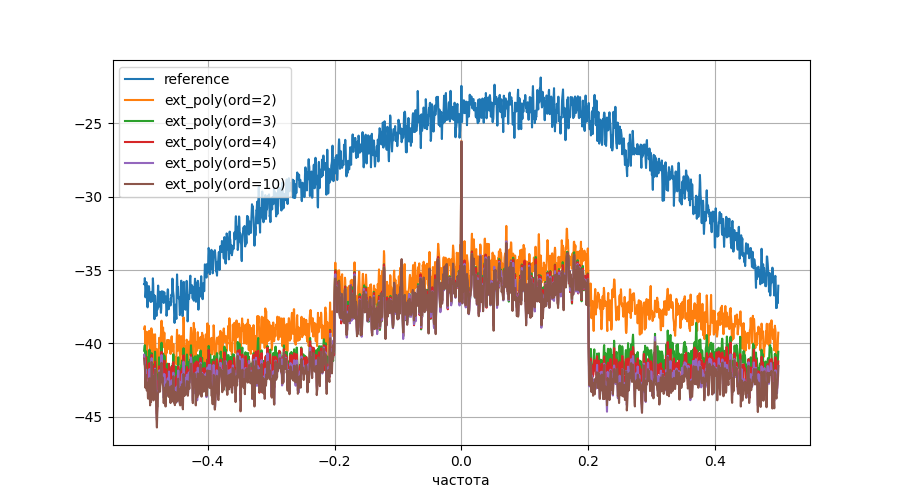

In [53]:
# here we test different polynomial orders with learnable all
%matplotlib notebook

# try polynomial of different orders
ext_poly_mx_delay = 9
ext_poly_orders = [2, 3, 4, 5, 10]
ext_poly_generator = ('cheby1', gen_cheby1_poly)
ext_poly_learnable = learnable_all(ext_poly_mx_delay)

ext_poly_errs = []

for ext_poly_ord in ext_poly_orders:
    _, y_ext = extended_polynomial(a_in, a_ref, ext_poly_mx_delay, 
                                     ext_poly_ord, poly_generator=ext_poly_generator[1],
                                     rcond=5e-19, learnable=ext_poly_learnable)
    ext_poly_errs.append(a_ref-y_ext)

fig, ax = plt.subplots(1, 1, figsize=(9, 5))
plot_psd([a_ref] + ext_poly_errs, ax=ax)

legend = ['reference'] + ['ext_poly(ord={})'.format(order) for order in ext_poly_orders]
plt.legend(legend)

<IPython.core.display.Javascript object>


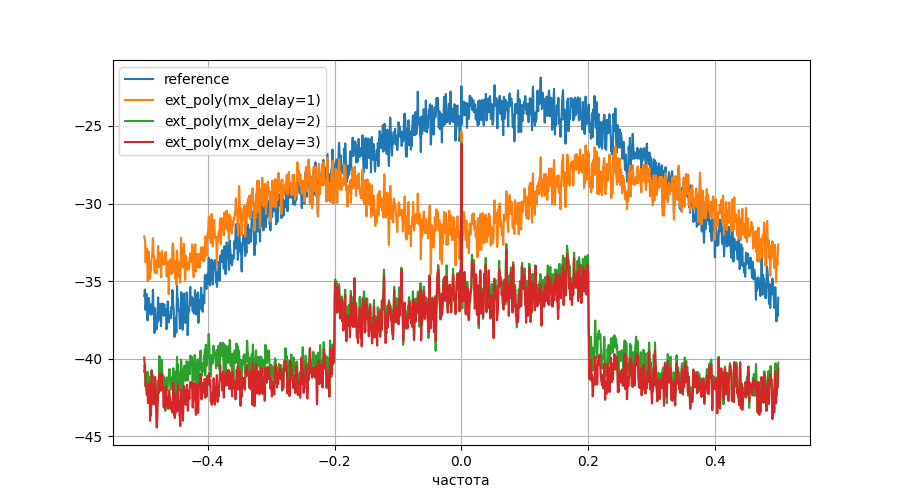

In [104]:
# here we test different mx_delay
%matplotlib notebook

ext_poly_mx_delays = [1, 2, 3]
ext_poly_order = 3
ext_poly_generator = ('cheby1', gen_cheby1_poly)
ext_poly_learnable = learnable_all(ext_poly_mx_delay)

ext_poly_errs = []

for ext_poly_mx_delay in ext_poly_mx_delays:
    _, y_ext = extended_polynomial(a_in, a_ref, ext_poly_mx_delay, 
                                     ext_poly_ord, poly_generator=ext_poly_generator[1],
                                     rcond=5e-19, learnable=learnable_all(ext_poly_mx_delay))
    ext_poly_errs.append(a_ref-y_ext)

fig, ax = plt.subplots(1, 1, figsize=(9, 5))
plot_psd([a_ref] + ext_poly_errs, ax=ax)

legend = ['reference'] + ['ext_poly(mx_delay={})'.format(ext_poly_mx_delay) for ext_poly_mx_delay in ext_poly_mx_delays]
plt.legend(legend)

<IPython.core.display.Javascript object>


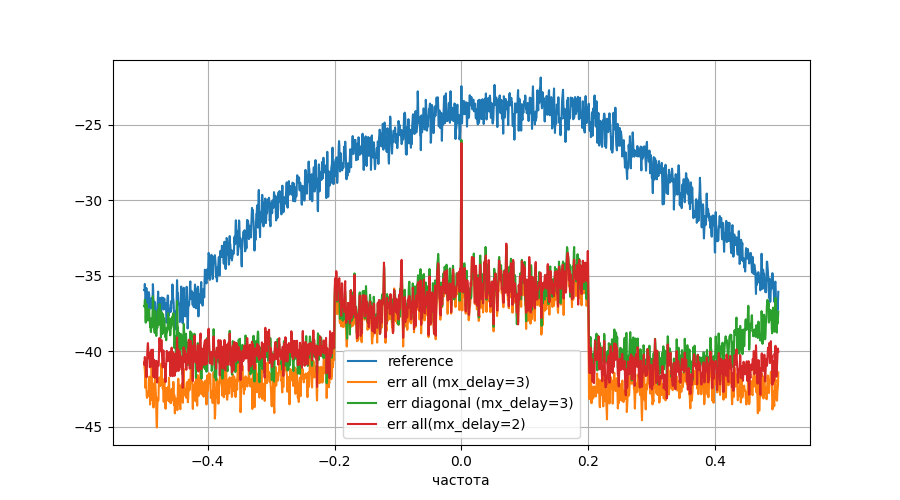

In [121]:
# here we test learnable
%matplotlib notebook

ext_poly_mx_delay = 3
ext_poly_order = 5
ext_poly_generator = ('cheby1', gen_hermit_poly)

#ext_learnable_custom = learnable_diag(ext_poly_mx_delay)
#ext_learnable_custom[1, 0] = 1
ext_learnable_custom = np.array([[0, 0, 0, 0, 0, 0, 0],
                                 [0, 0, 0, 0, 0, 0, 0], 
                                 [0, 1, 1, 0, 0, 0, 0], 
                                 [0, 1, 1, 1, 0, 0, 0], 
                                 [0, 1, 1, 0, 0, 0, 0], 
                                 [0, 0, 0, 0, 0, 0, 0], 
                                 [0, 0, 0, 0, 0, 0, 0]])



w_ext_all, y_ext_all = extended_polynomial(a_in, a_ref, ext_poly_mx_delay, 
                                 ext_poly_order, poly_generator=ext_poly_generator[1],
                                 rcond=5e-19, learnable=learnable_all(ext_poly_mx_delay))
ext_poly_errs_all = a_ref-y_ext_all

_, y_ext_diag = extended_polynomial(a_in, a_ref, ext_poly_mx_delay, 
                                 ext_poly_ord, poly_generator=ext_poly_generator[1],
                                 rcond=5e-19, learnable=learnable_diag(ext_poly_mx_delay))
ext_poly_errs_diag = a_ref-y_ext_diag

_, y_ext_custom = extended_polynomial(a_in, a_ref, ext_poly_mx_delay, 
                                 ext_poly_ord, poly_generator=ext_poly_generator[1],
                                 rcond=5e-19, learnable=ext_learnable_custom)
ext_poly_errs_custom = a_ref-y_ext_custom


fig, ax = plt.subplots(1, 1, figsize=(9, 5))
plot_psd([a_ref, ext_poly_errs_all, ext_poly_errs_diag, ext_poly_errs_custom], ax=ax)

legend = ['reference', 'err all (mx_delay=3)', 'err diagonal (mx_delay=3)', 'err all(mx_delay=2)']
plt.legend(legend)

<IPython.core.display.Javascript object>


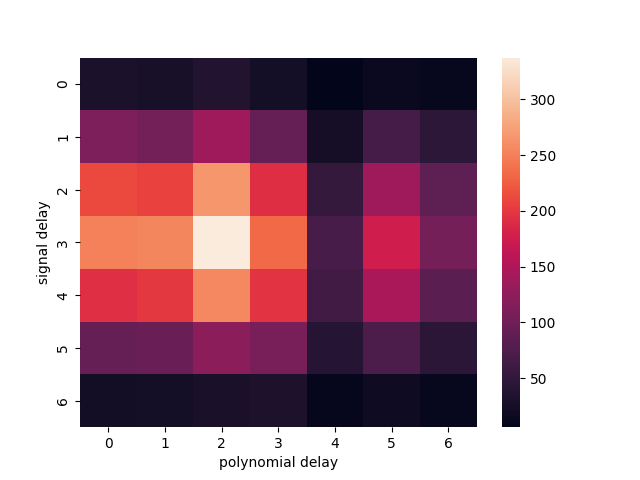

Text(0.5, 23.52222222222222, 'polynomial delay')

In [122]:
%matplotlib notebook

# let's mean over polynomial orders excluding 0 cause it always have only diagonal
heatmap = np.mean(np.abs(w_ext_all)[1:], axis=0)

#ax = sns.heatmap(heatmap)
ax = sns.heatmap(np.abs(w_ext_all)[3])
ax.set_ylabel('signal delay')
ax.set_xlabel('polynomial delay')

In [83]:
heatmap

array([[0.988, 0.819, 0.132],
       [1.794, 1.446, 0.286],
       [0.257, 0.528, 0.342]])